<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/ValidacionDeModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de análisis de Matriz de confusión

A continuación una regresión logística que clasifica una base de datos muy conocida como es IRIS.

Hay que estudiar que se requiere un grupo "test", en este caso de 30 referencias que el modelo "no conoce" para evaluar su capacidad de clasificación.

En este caso, se clasifican los 30 perfectamente.

Para analizar la matriz de confusión adecuadamente, podemos calcular diversas métricas que nos permitirán evaluar el rendimiento del modelo de regresión logística en la predicción de la supervivencia de los pasajeros del Titanic. Las métricas más comunes son:

Precisión (Accuracy): Es la proporción de predicciones correctas (tanto verdaderos positivos como verdaderos negativos) en relación al total de predicciones.

$
 \text{Precisión} = \frac{TP + TN}{TP + TN + FP + FN}
 $

Precisión Positiva (Precision): Es la proporción de verdaderos positivos en relación al total de positivos predichos.

$
 \text{Precisión Positiva} = \frac{TP}{TP + FP}
 $

Sensibilidad (Recall o True Positive Rate): Es la proporción de verdaderos positivos en relación al total de positivos reales.

$
 \text{Sensibilidad} = \frac{TP}{TP + FN}
$

Especificidad (True Negative Rate): Es la proporción de verdaderos negativos en relación al total de negativos reales.

$
 \text{Especificidad} = \frac{TN}{TN + FP}
$

F1 Score: Es una medida de la precisión y la sensibilidad. Es útil cuando hay una clase desbalanceada.

 $
 \text{F1 Score} = 2 \times \frac{\text{Precisión Positiva} \times \text{Sensibilidad}}{\text{Precisión Positiva} + \text{Sensibilidad}}
$

# EJEMPLO DE COMPARACIÓN DE MODELOS

Cargamos la base de datos Pima Indian.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# URL del dataset Pima Indian Diabetes (puedes modificarla si el archivo está en local)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Nombres de las columnas del dataset
column_names = [
    "Number of Pregnancies",
    "Glucose",
    "Blood Pressure",
    "Skin Thickness",
    "Insulin",
    "BMI",
    "Diabetes Pedigree Function",
    "Age",
    "Class"
]

# Cargar la base de datos
data = pd.read_csv(url, header=None, names=column_names)
data.head()


,Number of Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# ¿Qué es un Gráfico de Pares?

Un **gráfico de pares**, también conocido como **pair plot**, es una herramienta de visualización utilizada para explorar las relaciones entre múltiples variables en un conjunto de datos. Este tipo de gráfico es especialmente útil para entender cómo se relacionan diferentes variables entre sí y es comúnmente utilizado en análisis exploratorio de datos.

## Características Principales

- **Matriz de Gráficos**: Un gráfico de pares presenta una matriz de gráficos de dispersión (scatter plots) donde cada gráfico muestra la relación entre dos variables. La diagonal de la matriz a menudo muestra histogramas o gráficos de densidad de cada variable, lo que permite observar la distribución de las mismas.

- **Comparación Visual**: Permite comparar visualmente varias variables simultáneamente, lo que facilita identificar patrones, tendencias y posibles correlaciones.

- **Coloreado por Clases**: A menudo, se utiliza el parámetro `hue` para diferenciar las clases en los datos (por ejemplo, en un problema de clasificación, los puntos se pueden colorear según la etiqueta de clase). Esto ayuda a observar cómo se distribuyen las clases en relación con las diferentes variables.

## Usos Comunes

- **Análisis Exploratorio de Datos (EDA)**: Ideal para la etapa de exploración, antes de aplicar modelos estadísticos o de machine learning, ya que ayuda a identificar relaciones y posibles problemas como la multicolinealidad.

- **Detección de Outliers**: Facilita la identificación de valores atípicos que pueden influir en los resultados del análisis.

- **Selección de Variables**: Ayuda a determinar qué variables pueden ser más relevantes para incluir en modelos predictivos basándose en las relaciones observadas.

## Ejemplo de Uso

Imagina que tienes un conjunto de datos sobre la salud de pacientes, incluyendo características como la presión arterial, el índice de masa corporal (IMC) y la edad. Un gráfico de pares te permitirá visualizar cómo cada una de estas variables se relaciona con las demás y si hay alguna correlación evidente entre ellas, además de cómo se distribuyen las clases (por ejemplo, pacientes diabéticos versus no diabéticos).

## Conclusión

Los gráficos de pares son herramientas poderosas para la visualización de datos, proporcionando una forma clara y concisa de acceder a información compleja, facilitando así el trabajo de análisis en ciencia de datos y estadística.

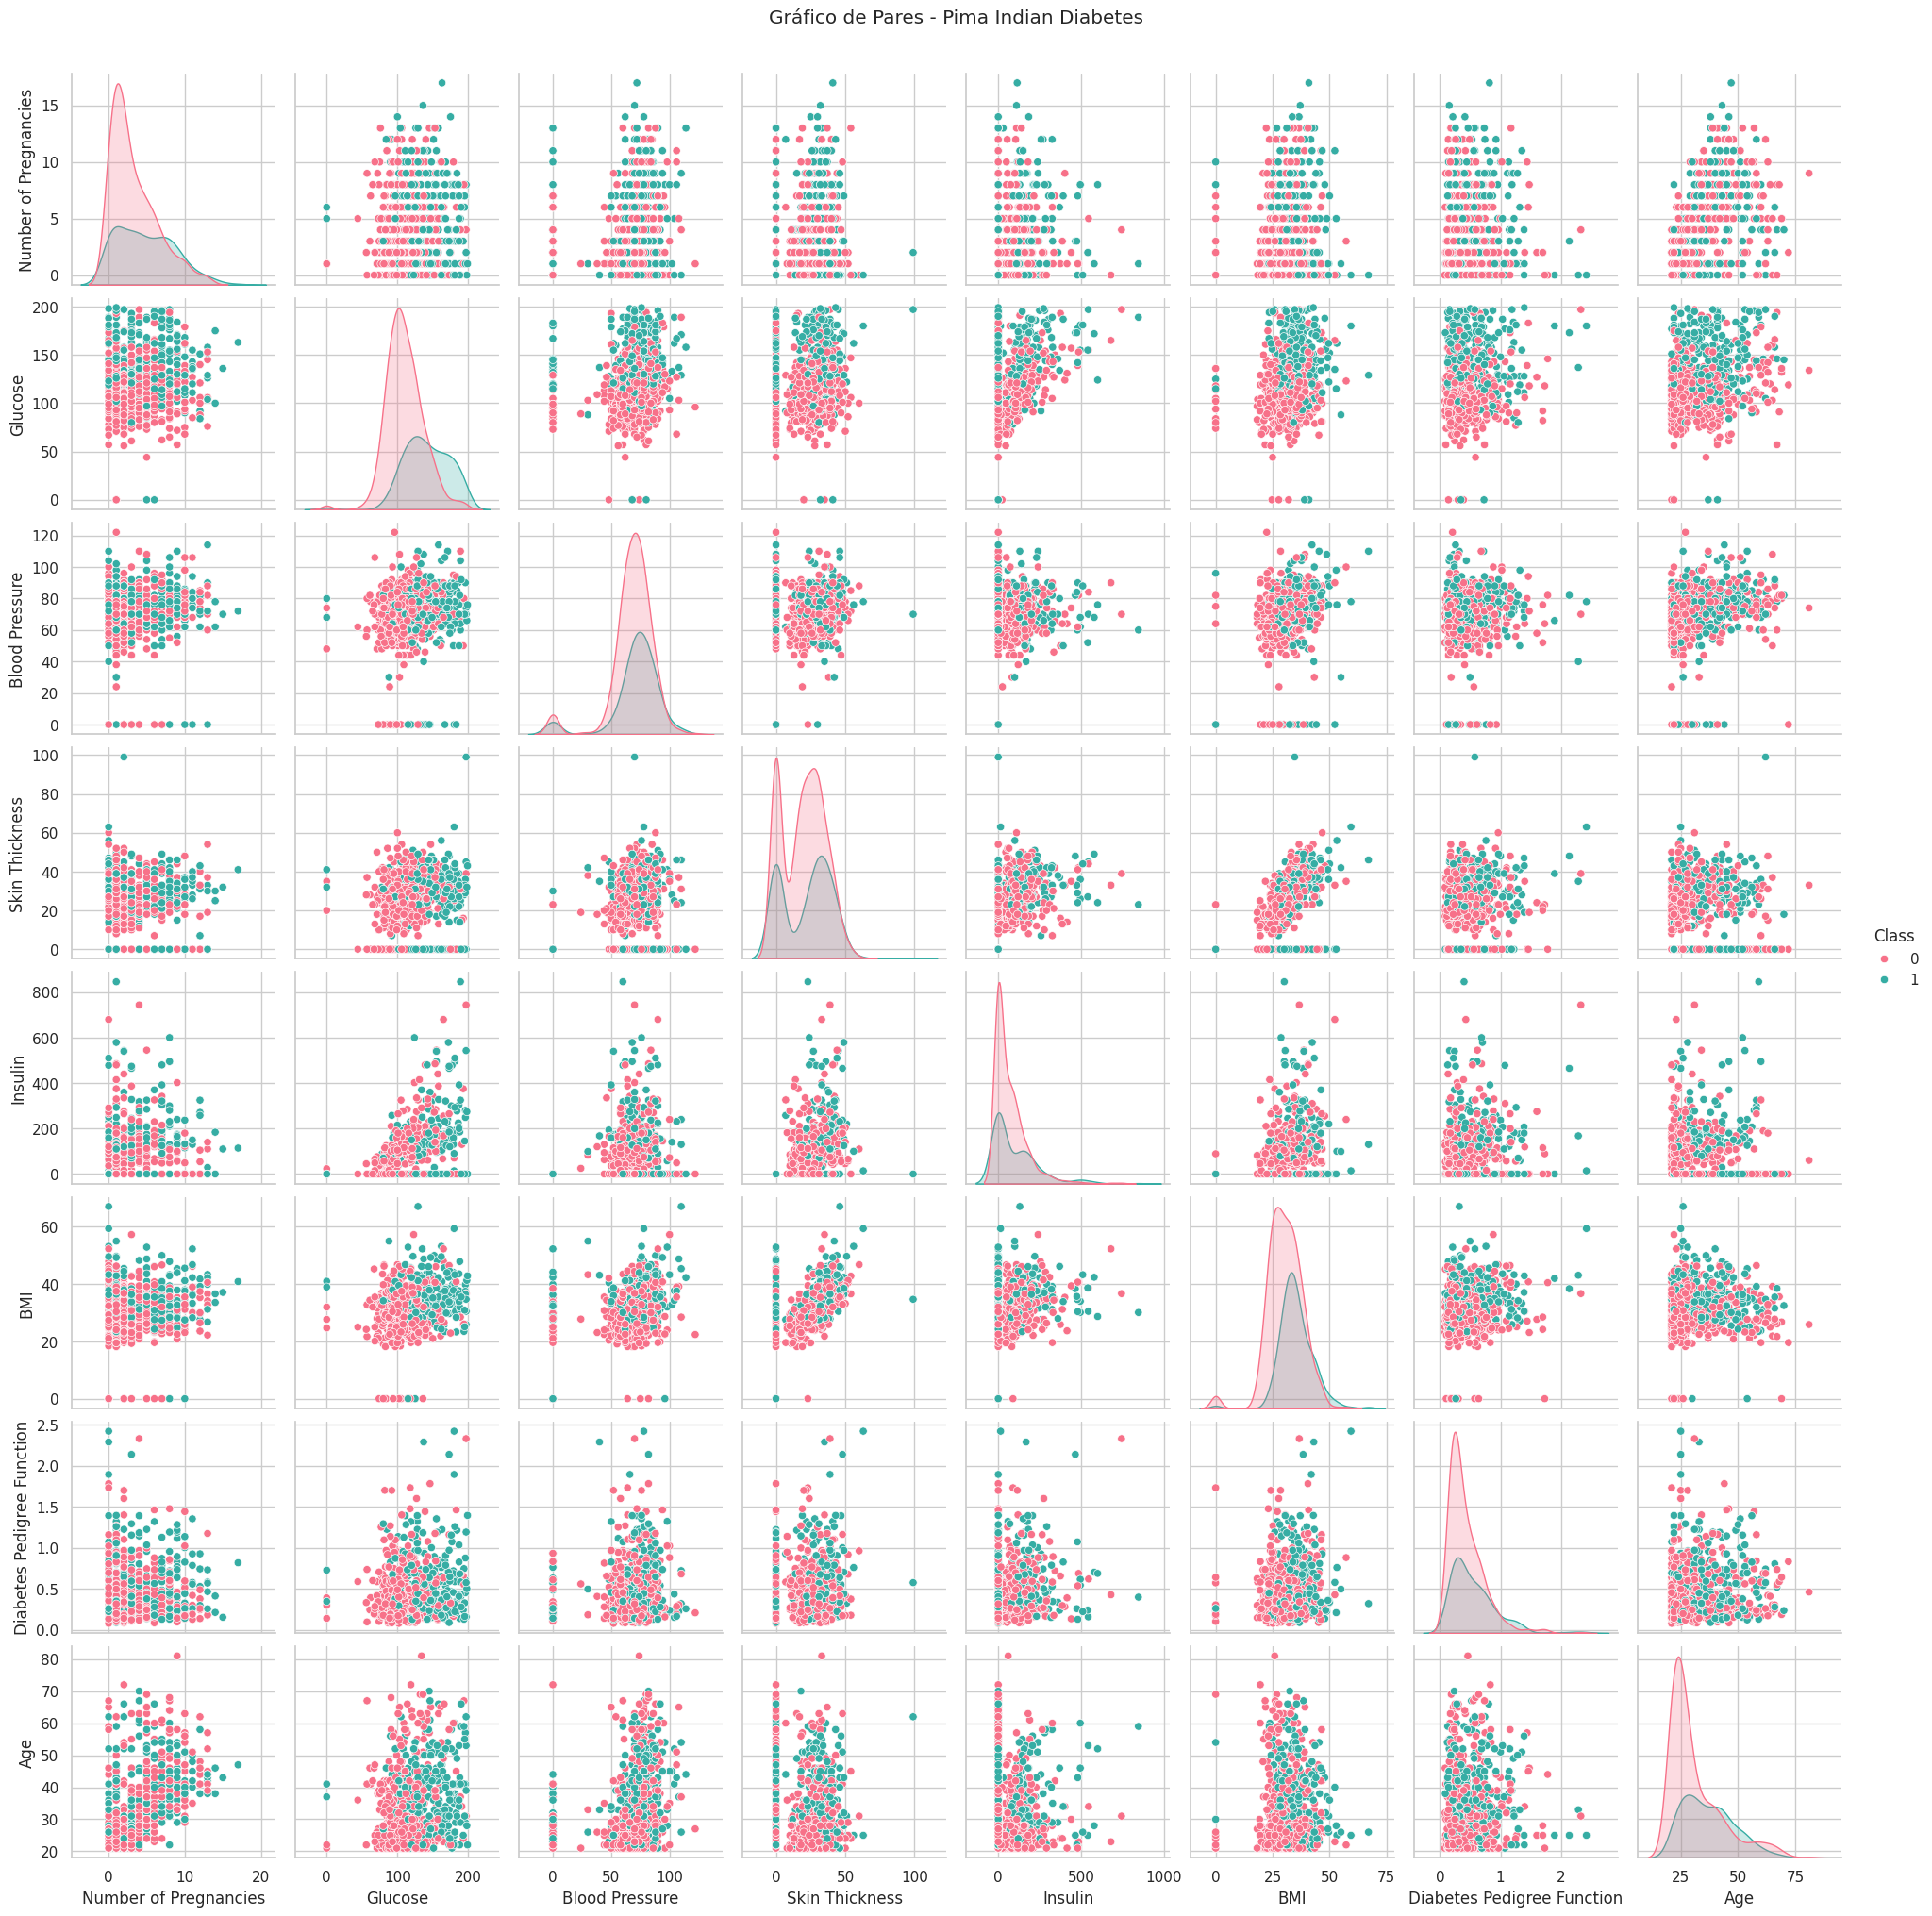

In [5]:
sns.set(style="whitegrid")

# Crear un gráfico pairplot
pairplot = sns.pairplot(data, hue="Class", palette="husl")

# Mostrar el gráfico
plt.suptitle("Gráfico de Pares - Pima Indian Diabetes", y=1.02)
plt.show()

# COMPARAMOS MODELOS

Lanzamos 3 modelos para compararlos.
- Un análisis discriminante lineal.
- Una regresión logística.
- Ramdom Forest


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Creamos un conjunto de entrenamiento y otro de test para la validación del modelo

In [7]:
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop("Class", axis=1)
y = data["Class"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Lanzamos los 3 modelos

In [8]:
# Inicializar modelos
lda_model = LDA()
logistic_model = LogisticRegression(max_iter=200)
rf_model = RandomForestClassifier(random_state=42)

# Entrenar modelos
lda_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Hacer predicciones
lda_predictions = lda_model.predict(X_test)
logistic_predictions = logistic_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

## Creamos las matrices de confusión


--- LDA ---
Matriz de Confusión:
[[80 19]
 [18 37]]
Análisis de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



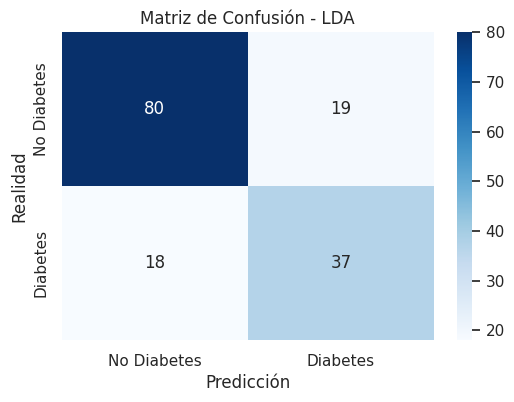


--- Logistic Regression ---
Matriz de Confusión:
[[78 21]
 [18 37]]
Análisis de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



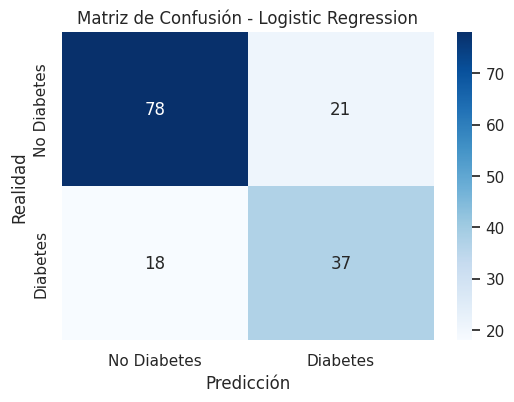


--- Random Forest ---
Matriz de Confusión:
[[77 22]
 [21 34]]
Análisis de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



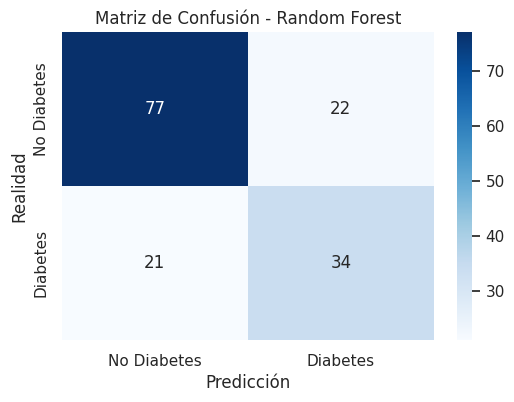

In [9]:
# Crear matriz de confusión y análisis de clasificación para cada modelo
models = {'LDA': lda_predictions, 'Logistic Regression': logistic_predictions, 'Random Forest': rf_predictions}

for model_name, predictions in models.items():
    print(f"\n--- {model_name} ---")
    print("Matriz de Confusión:")
    cm = confusion_matrix(y_test, predictions)
    print(cm)

    report = classification_report(y_test, predictions)
    print("Análisis de Clasificación:")
    print(report)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

# Vamos a calcular qué valor umbral (threshold) podría interesar

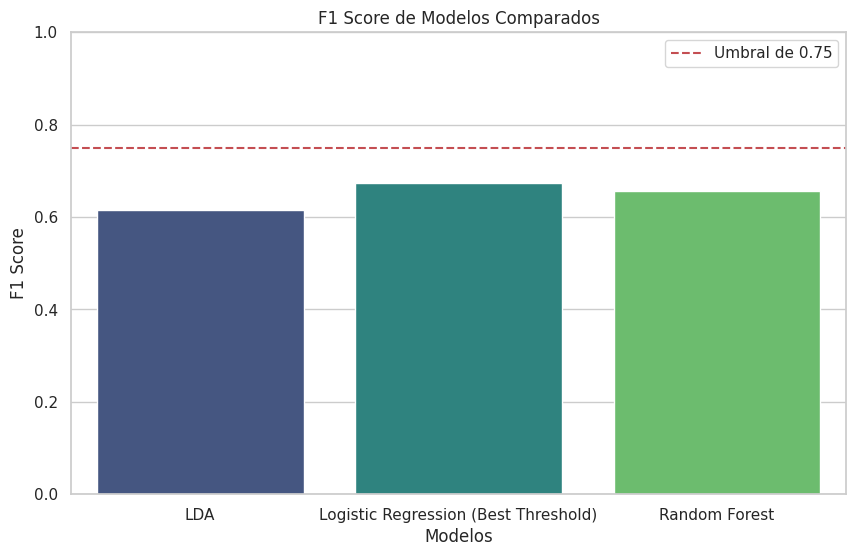

Mejor F1 para LDA: 0.6666666666666666
Mejor F1 para Regresión Logística: 0.6730769230769231, Umbral: 0.55
Mejor F1 para Random Forest: 0.6567189936748442, n_estimators: {'n_estimators': 200}


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV # Import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np
# Evaluar LDA con búsqueda de hiperparámetros
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],  # Excluir 'svd' porque no soporta shrinkage
    'shrinkage': [None, 'auto'] + list(np.arange(0.0, 1.1, 0.1))  # Válido solo para 'lsqr'
}

lda_model = LDA()
grid_lda = GridSearchCV(lda_model, param_grid_lda, scoring='f1', cv=5)
grid_lda.fit(X_train, y_train)
best_lda_model = grid_lda.best_estimator_
best_lda_f1 = grid_lda.best_score_
best_lda_params = grid_lda.best_params_

# Evaluar Regresión Logística con ajuste de umbral
logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(X_train, y_train)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_logistic = []

for threshold in thresholds:
    y_pred_logistic = (y_prob_logistic >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_logistic)
    f1_scores_logistic.append(f1)

best_threshold_logistic = thresholds[np.argmax(f1_scores_logistic)]
best_f1_logistic = max(f1_scores_logistic)

# Evaluar Random Forest con GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [10, 50, 100, 200]}  # Exploramos diferentes cantidades de árboles
grid_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1', cv=5)
grid_rf.fit(X_train, y_train)
rf_f1 = grid_rf.best_score_
best_n_estimators_rf = grid_rf.best_params_

# Gráfica de resultados
models = ['LDA', 'Logistic Regression (Best Threshold)', 'Random Forest']
f1_scores = [best_lda_f1, best_f1_logistic, rf_f1]

plt.figure(figsize=(10, 6))
sns.barplot(hue=models, x=models, y=f1_scores, palette='viridis')
plt.title('F1 Score de Modelos Comparados')
plt.ylabel('F1 Score')
plt.xlabel('Modelos')
plt.ylim(0, 1)  # Los valores del F1 Score están en el rango de 0 a 1
plt.axhline(0.75, color='r', linestyle='--', label='Umbral de 0.75')
plt.legend()
plt.show()

# Mostrar los mejores parámetros y resultados
print(f"Mejor F1 para LDA: {lda_f1}")
print(f"Mejor F1 para Regresión Logística: {best_f1_logistic}, Umbral: {best_threshold_logistic}")
print(f"Mejor F1 para Random Forest: {rf_f1}, n_estimators: {best_n_estimators_rf}")

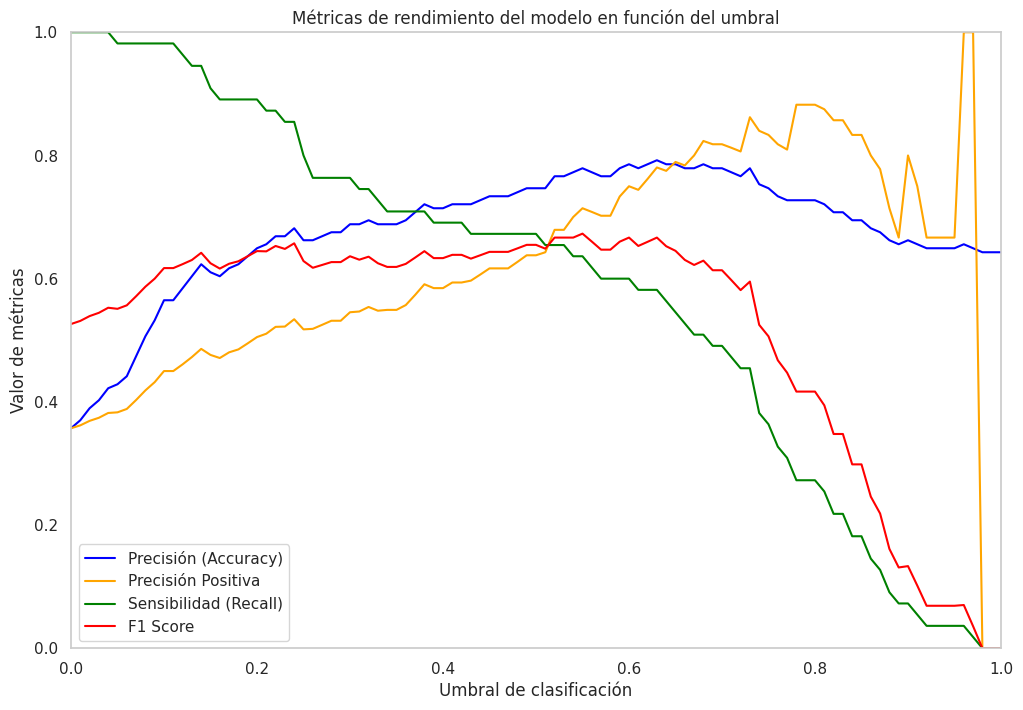

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predecir probabilidades
y_probs = logistic_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

# Inicializar listas para almacenar resultados
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Calcular métricas para cada umbral
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Clasificación según el umbral
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Gráfico de métricas en función del umbral
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, label='Precisión (Accuracy)', color='blue')
plt.plot(thresholds, precisions, label='Precisión Positiva', color='orange')
plt.plot(thresholds, recalls, label='Sensibilidad (Recall)', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.title('Métricas de rendimiento del modelo en función del umbral')
plt.xlabel('Umbral de clasificación')
plt.ylabel('Valor de métricas')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [19]:
# Encontrar el umbral óptimo para el F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"El mejor umbral para el F1-score es: {best_threshold:.2f}")
print(f"El mejor F1-score es: {best_f1_score:.2f}")

El mejor umbral para el F1-score es: 0.55
El mejor F1-score es: 0.67


## Explicación del gráfico

En un modelo de **regresión logística**, la salida es una probabilidad que indica la posibilidad de que una observación pertenezca a la clase positiva (en este caso, que un pasajero sobrevivió). Sin embargo, para clasificar los datos en categorías discretas (0 o 1), necesitamos definir un umbral. Por ejemplo, si establecemos un umbral de 0.5, cualquier observación con una probabilidad superior a 0.5 será clasificada como 1 (sobreviviente), y aquellas con una probabilidad inferior serán clasificadas como 0 (no sobreviviente).

Detalle del Proceso
Probabilidades Predichas:
```
`y_probs = model.predict_proba(X_test)[:, 1]`
```
Aquí, model.predict_proba(X_test) devuelve una matriz de probabilidades para cada clase.

La columna [:, 1] selecciona las probabilidades de la clase positiva (sobreviviente) de cada observación en el conjunto de prueba.
Definición de Umbrales:

```
`thresholds = np.arange(0.0, 1.01, 0.01)`
```

Creamos un rango de umbrales desde 0.0 hasta 1.0 en incrementos de 0.01. Esto nos dará 101 umbrales diferentes para evaluar.
Inicialización de Listas para Resultados:

```
accuracies = []
precisions = []
recalls = []
f1_scores = []
```
Inicializamos listas vacías para almacenar los resultados de las métricas correspondientes a cada umbral.
Cálculo de Métricas para Cada Umbral:




```
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Clasificación según el umbral
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
```




Iteramos sobre cada umbral en la lista de umbrales.
Clasificación según el Umbral:
```
y_pred = (y_probs >= threshold).astype(int)
```
Esta línea convierte las probabilidades en clases. Si la probabilidad de un pasajero es mayor o igual al umbral actual, se clasifica como 1 (sobreviviente), de lo contrario se clasifica como 0 (no sobreviviente).

**Cálculo de Métricas:**

Después de obtener las predicciones y_pred, calculamos las métricas de rendimiento:
Accuracy: Proporción de clasificaciones correctas.
Precisión: Proporción de verdaderos positivos en relación a todos los positivos predichos.
Sensibilidad: Proporción de verdaderos positivos en relación a todos los positivos reales.
F1 Score: Promedio armónico de precisión y sensibilidad.

Usamos las listas que inicializamos para almacenar los resultados de cada métrica para cada umbral.

**Resumen**

Este proceso de iteración sobre diferentes umbrales nos permite observar cómo varían las métricas de desempeño del modelo, lo cual es crucial para entender el balance entre la precisión y la sensibilidad. Al graficar estas métricas en función de los umbrales, se puede visualizar qué tan bien se comporta el modelo con distintos umbrales de decisión, ayudando a determinar cuál puede ser el mejor umbral para un caso específico en función de las necesidades del problema o negocio.

## Curvas ROC
La curva ROC es un gráfico que ilustra el rendimiento de un modelo de clasificación binaria a través de diferentes umbrales de decisión, mostrando la relación entre la Tasa de Verdaderos Positivos (TPR) y la Tasa de Falsos Positivos (FPR).

**Tasa de Verdaderos Positivos (TPR):**

También conocida como Sensibilidad o Recall.
Se calcula como:
 $$ \text{TPR} = \frac{TP}{TP + FN} $$
Representa la proporción de positivos reales que son correctamente identificados por el modelo.
Tasa de Falsos Positivos (FPR):

Se calcula como: $$ \text{FPR} = \frac{FP}{FP + TN} $$
Representa la proporción de negativos reales que son incorrectamente identificados como positivos.
Relación con el Análisis de Umbrales
Generación de Curvas ROC:

Al igual que en el análisis de umbrales, cuando evaluamos un modelo de clasificación en función de diferentes umbrales, se pueden calcular las tasas TPR y FPR para cada umbral.
Para cada umbral, se puede determinar cuántos verdaderos positivos y falsos positivos se producen, permitiendo trazar los puntos (FPR, TPR).

**Visualización:**

La curva ROC se traza con la Tasa de Falsos Positivos en el eje X y la Tasa de Verdaderos Positivos en el eje Y.
Un modelo ideal alcanzaría una TPR del 1 (todas las positivas correctamente identificadas) y una FPR de 0 (ninguna negativa identificada incorrectamente). Este punto se encuentra en la esquina superior izquierda.

**Área Bajo la Curva (AUC):**

El área bajo la curva ROC (AUC, por sus siglas en inglés) se utiliza como una métrica para evaluar el rendimiento del modelo. Un AUC de 1 indica un modelo perfecto, mientras que un AUC de 0.5 indica un modelo que no es mejor que una clasificación aleatoria.

A medida que se evalúan diferentes umbrales, el AUC ofrece una medida global de la capacidad del modelo para discriminar entre las clases.

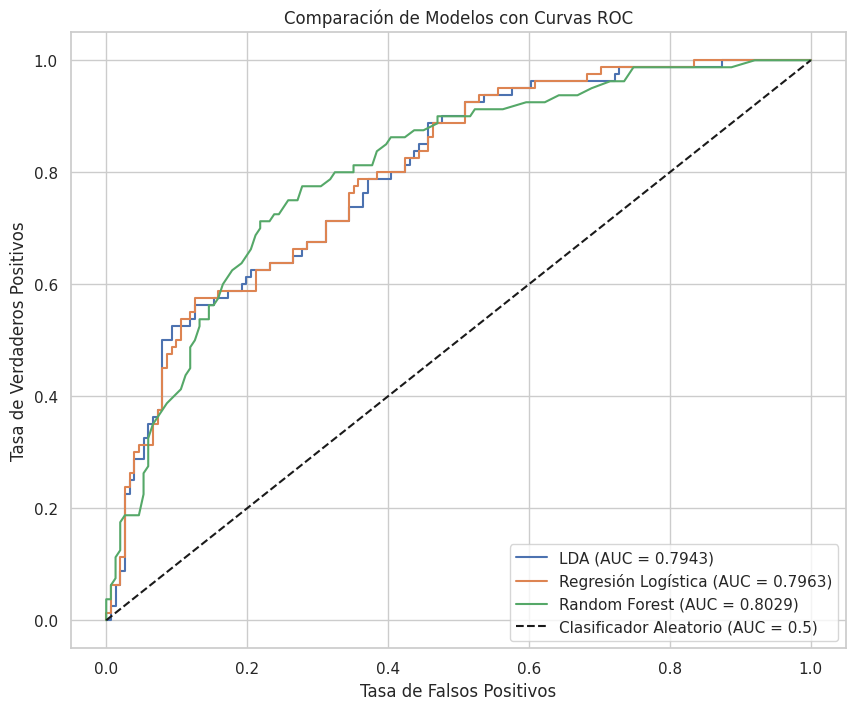

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Cargar los datos
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columnas = ['Embarazos', 'Glucosa', 'PresionArterial', 'GrosorPiel',
           'Insulina', 'IMC', 'PedigriDiabetes', 'Edad', 'Resultado']
df = pd.read_csv(url, names=columnas)

# Manejo de valores faltantes
columnas_imputar = ['Glucosa', 'PresionArterial', 'GrosorPiel', 'Insulina', 'IMC']
df[columnas_imputar] = df[columnas_imputar].replace(0, np.nan)
imputador = SimpleImputer(strategy='mean')
df[columnas_imputar] = imputador.fit_transform(df[columnas_imputar])

# Dividir datos
X = df.drop('Resultado', axis=1)
y = df['Resultado']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_esc = scaler.fit_transform(X_train)
X_test_esc = scaler.transform(X_test)

# Inicializar modelos
modelos = {
    'LDA': LinearDiscriminantAnalysis(),
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Entrenar modelos y calcular métricas ROC
plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    modelo.fit(X_train_esc, y_train)
    y_proba = modelo.predict_proba(X_test_esc)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.4f})')

# Configurar gráfico
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Modelos con Curvas ROC')
plt.legend(loc='lower right')
plt.show()

**Resumen**

La relación entre el análisis de umbrales y la curva ROC es esencial, ya que ambos enfoques evalúan el modelo a través de diferentes umbrales de decisión. La curva ROC proporciona una visualización y una evaluación más refinada del rendimiento del modelo en comparación con el análisis de métricas a un único umbral. Al observar la curva ROC, se puede decidir intuitivamente un umbral que balancee la tasa de verdaderos y falsos positivos de acuerdo con los objetivos específicos del problema en cuestión.

## El índice Youden

El índice Youden es una métrica que se utiliza para evaluar la efectividad de un modelo de clasificación binaria, integrando tanto la tasa de verdaderos positivos (TPR, también conocida como sensibilidad) como la tasa de falsos positivos (FPR). Su propósito es proporcionar un único número que resuma el rendimiento del modelo a través de diferentes umbrales, y se utiliza en conjunción con el gráfico ROC (Receiver Operating Characteristic).

Definición del Índice Youden
El índice Youden se define como:

$$
J = \text{TPR} - \text{FPR}
$$

o, en términos de sensibilidad y especificidad:

$$
J = \text{Sensibilidad} + \text{Especificidad} - 1
$$

donde:

TPR (Sensibilidad) es la proporción de positivos correctos identificados por el modelo.

FPR es la proporción de negativos incorrectamente clasificados como positivos.
Especificidad es la proporción de negativos correctos identificados por el modelo.

**Interpretación del Índice Youden**

Valor del Índice Youden:

Ranges from 0 to 1: Un índice Youden de 1 indica un modelo perfecto (todas las verdaderas positivas y ninguna falsa positiva), mientras que un índice de 0 indica que el modelo es inútil (no identifica correctamente ni una sola clase).

**Optimal Threshold:** Un índice Youden más alto corresponde a un umbral que maximiza la diferencia entre la TPR y la FPR. Este umbral sería ideal para lograr un buen equilibrio en la clasificación.

**Conexión con la Curva ROC:**

En la curva ROC, se pueden calcular los índices Youden para cada punto (cada umbral). En este sentido, el índice Youden ayuda a identificar el umbral que produce la mejor combinación de sensibilidad y especificidad.
Seleccionando el Umbral Óptimo:

Si se trazan los valores del índice Youden en función de los diferentes umbrales, se puede identificar el umbral que maximiza este índice, lo que resulta en una clasificación óptima según las condiciones del problema.

**Cálculo Práctico del Índice Youden**

A continuación, te muestro cómo calcular el índice Youden para los diferentes umbrales en el contexto del modelo de regresión logística:


Resultados con LDA:
Sensibilidad: 0.673
Especificidad: 0.808
Índice Youden: 0.481

Resultados con Regresión Logística:
Sensibilidad: 0.673
Especificidad: 0.798
Índice Youden: 0.471

Resultados con Bosque Aleatorio:
Sensibilidad: 0.600
Especificidad: 0.778
Índice Youden: 0.378


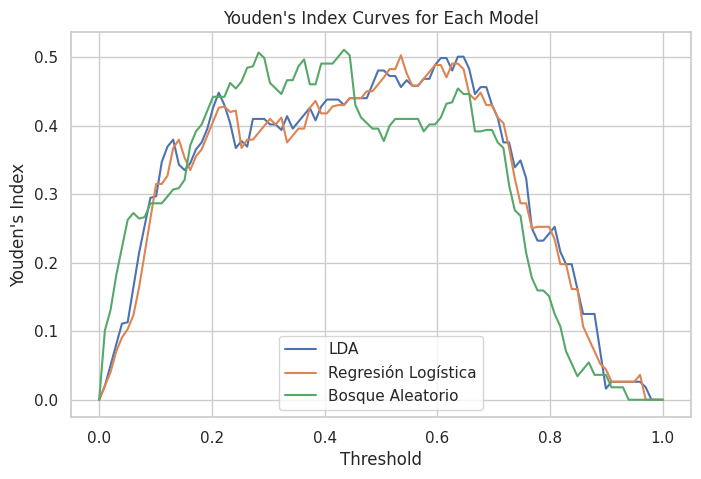


Observación:
Las curvas representan el Índice Youden para cada umbral. Los umbrales pueden ajustarse según los objetivos específicos de la aplicación.


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Función para calcular el Índice Youden a partir de las probabilidades
def calculate_youden_from_prob(probabilities, threshold):
    y_true = (y_test == 1).astype(int)  # Assuming positive class is 1
    # Convert probabilities to class predictions using threshold
    y_pred = (probabilities >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle zero division
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle zero division
    return sensitivity - (1 - specificity)

# Function to plot Youden's Index curve against thresholds
def plot_youden_curve(models, model_names, X_test_std, y_test):
    plt.figure(figsize=(8, 5))
    plt.xlabel('Threshold')
    plt.ylabel('Youden\'s Index')
    plt.title('Youden\'s Index Curves for Each Model')

    for i, (model, name) in enumerate(zip(models, model_names)):
        youden_values = []
        thresholds = np.linspace(0, 1, 100)

        for threshold in thresholds:
            # Get predicted probabilities for positive class (index 1)
            probabilities = model.predict_proba(X_test_std)[:, 1]
            youden = calculate_youden_from_prob(probabilities, threshold)
            youden_values.append(youden)

        plt.plot(thresholds, youden_values, label=f'{name}')

    plt.legend()
    plt.grid(True)
    plt.show()



# Estandarizar las variables
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Función para calcular el Índice Youden
def calculate_youden(sensitivity, specificity):
    return sensitivity - (1 - specificity)

# Entrenar y evaluar cada modelo

# 1. LDA
print("\nResultados con LDA:")
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train_std, y_train)
y_pred_lda = model_lda.predict(X_test_std)

cm_lda = confusion_matrix(y_test, y_pred_lda)
tn, fp, fn, tp = cm_lda.ravel()
sensitivity_lda = tp / (tp + fn)
specificity_lda = tn / (tn + fp)
youden_lda = calculate_youden(sensitivity_lda, specificity_lda)


print(f"Sensibilidad: {sensitivity_lda:.3f}")
print(f"Especificidad: {specificity_lda:.3f}")
print(f"Índice Youden: {youden_lda:.3f}")

# 2. Regresión Logística
print("\nResultados con Regresión Logística:")
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train_std, y_train)
y_pred_log = model_log.predict(X_test_std)

cm_log = confusion_matrix(y_test, y_pred_log)
tn, fp, fn, tp = cm_log.ravel()
sensitivity_log = tp / (tp + fn)
specificity_log = tn / (tn + fp)
youden_log = calculate_youden(sensitivity_log, specificity_log)


print(f"Sensibilidad: {sensitivity_log:.3f}")
print(f"Especificidad: {specificity_log:.3f}")
print(f"Índice Youden: {youden_log:.3f}")

# 3. Bosque Aleatorio
print("\nResultados con Bosque Aleatorio:")
model_ran = RandomForestClassifier(n_estimators=100)
model_ran.fit(X_train_std, y_train)
y_pred_ran = model_ran.predict(X_test_std)

cm_ran = confusion_matrix(y_test, y_pred_ran)
tn, fp, fn, tp = cm_ran.ravel()
sensitivity_ran = tp / (tp + fn)
specificity_ran = tn / (tn + fp)
youden_ran = calculate_youden(sensitivity_ran, specificity_ran)


print(f"Sensibilidad: {sensitivity_ran:.3f}")
print(f"Especificidad: {specificity_ran:.3f}")
print(f"Índice Youden: {youden_ran:.3f}")

# Graficar los Índices Youden en función de los umbrales
models = [model_lda, model_log, model_ran]
model_names = ['LDA', 'Regresión Logística', 'Bosque Aleatorio']
plot_youden_curve(models, model_names, X_test_std, y_test)

# Mensaje al usuario
print("\nObservación:")
print("Las curvas representan el Índice Youden para cada umbral. Los umbrales pueden ajustarse según los objetivos específicos de la aplicación.")


# Comparativa de los gráficos

Comparar este ejercicio basado en el índice Youden, y el anterior gráfico.

In [44]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar el conjunto de datos Titanic desde seaborn
titanic_data = sns.load_dataset('titanic')

# Preprocesamiento de datos
titanic_data.drop(columns=['embark_town', 'alive'], inplace=True)
titanic_data.dropna(subset=['age', 'embarked'], inplace=True)

# Convertir variables categóricas a variables dummy
titanic_data = pd.get_dummies(titanic_data, columns=['sex', 'embarked', 'class'], drop_first=True)

# Manejar la columna 'age'
titanic_data['age'] = titanic_data['age'].fillna(titanic_data['age'].mean())

# Definir características y variable objetivo
X = titanic_data.drop('survived', axis=1)
y = titanic_data['survived']

# Asegurarnos de que X solo contenga columnas numéricas
X = X.select_dtypes(include=[np.number])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predecir las probabilidades
y_probs = model.predict_proba(X_test)[:, 1]

# Inicializar listas para almacenar resultados
thresholds = np.arange(0.0, 1.01, 0.01)
youden_indices = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Calcular métricas e índice Youden para cada umbral
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Clasificación según el umbral

    # Agregar verificaciones para evitar divisiones por cero
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Calcular TPR y FPR para el índice Youden
    tpr = recall  # Verdaderos Positivos
    fpr = 1 - precision  # Falsos Positivos (1 - Especificidad)

    youden_index = tpr - fpr
    youden_indices.append(youden_index)

# Verificar que todas las métricas tienen el mismo tamaño
assert len(accuracies) == len(thresholds)
assert len(precisions) == len(thresholds)
assert len(recalls) == len(thresholds)
assert len(f1_scores) == len(thresholds)
assert len(youden_indices) == len(thresholds)



Umbral óptimo: 0.18
Valor del índice Youden: 0.4641889276035617


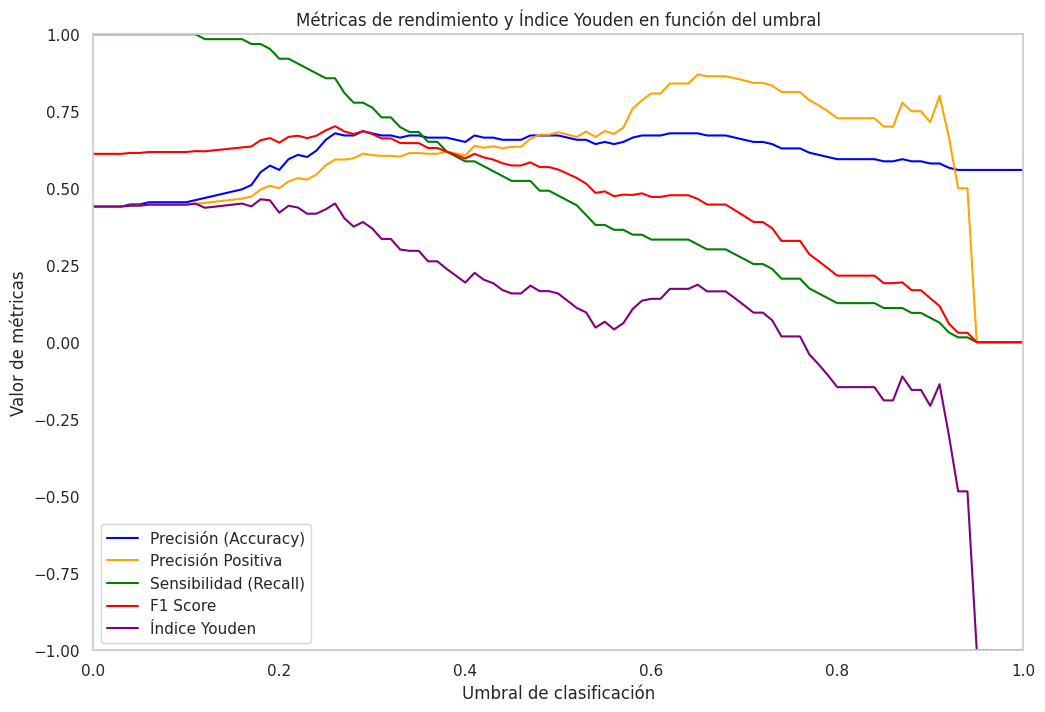

In [45]:
# Encontrar el umbral óptimo (donde el índice Youden es máximo)
optimal_idx = np.argmax(youden_indices)
optimal_threshold = thresholds[optimal_idx]
optimal_youden_value = youden_indices[optimal_idx]

# Imprimir el umbral óptimo y su valor de índice Youden
print("Umbral óptimo:", optimal_threshold)
print("Valor del índice Youden:", optimal_youden_value)

# Gráfico de métricas e índice Youden en función del umbral
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, label='Precisión (Accuracy)', color='blue')
plt.plot(thresholds, precisions, label='Precisión Positiva', color='orange')
plt.plot(thresholds, recalls, label='Sensibilidad (Recall)', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.plot(thresholds, youden_indices, label='Índice Youden', color='purple') # Agregar el índice Youden al gráfico
plt.title('Métricas de rendimiento y Índice Youden en función del umbral')
plt.xlabel('Umbral de clasificación')
plt.ylabel('Valor de métricas')
plt.xlim(0, 1)
plt.ylim(-1, 1) # Ajustar el límite inferior para visualizar mejor el índice Youden
plt.legend()
plt.grid()
plt.show()